In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Estimating our ARIMA baseline model

Following the arguments on economic forecasting outlined in Stock (2001), we first set out to assess which is the most adequate model that can be built to predict the Consumer Confidence Index (CCI) using only information about its lagged values. This model, Stock argues, should be the working baseline to which the predictive power of any new model considering external data should be compared.

In the Notebook below, we present a time series analysis of the CCI, considering whether it follows a random walk process, and studying the evolution of its stationary changes as a function of its own autoregressive and moving-average regressors. For this purpose, we discuss the optimal parameters of an ARIMA model without exogenous regressors.

## Summary of Key Results:
- Our best model for predicting CCI is an ARIMA model with AR(2), MA(3) and I(1).
- The in-sample R$^2$ of this model is 98.5%
- The Roll-forward R$^2$ of this model on the last year of CCI data is 35.6%

### Visualize data

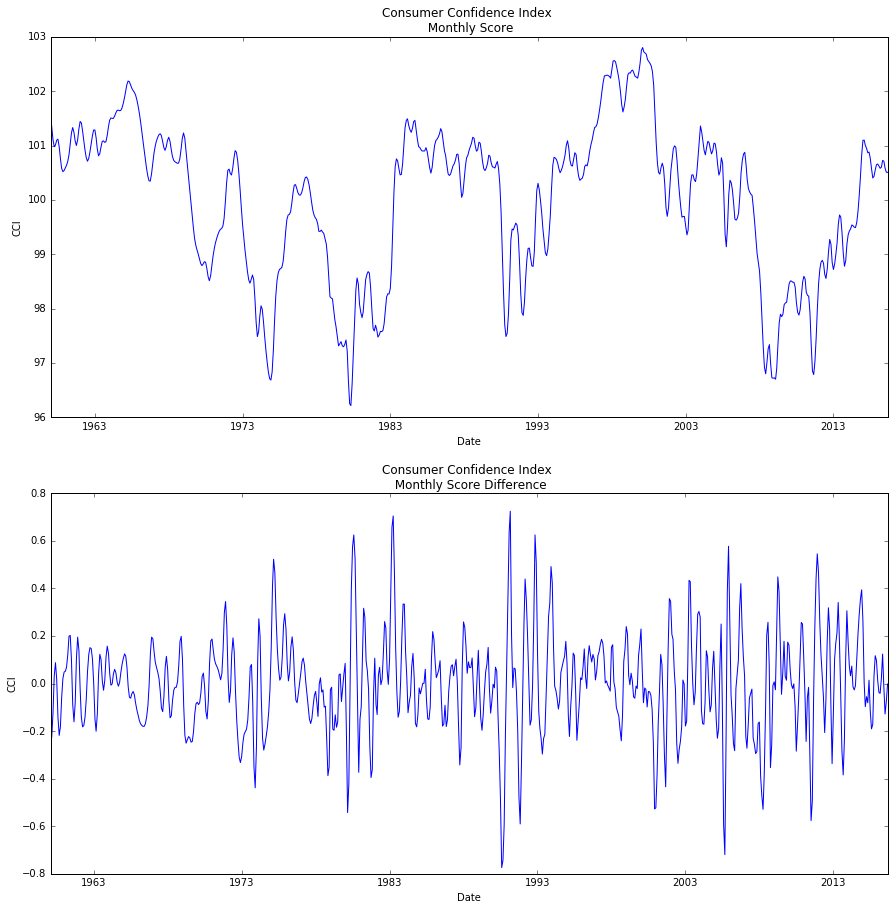

In [4]:
fig = plt.figure(figsize = (15, 15))

ax1 = fig.add_subplot(2, 1, 1)
ax1 = plt.plot(df)
ax1 = plt.title('Consumer Confidence Index \n Monthly Score')
ax1 = plt.xlabel('Date')
ax1 = plt.ylabel('CCI')

ax1 = fig.add_subplot(2, 1, 2)
ax1 = plt.plot(df.diff())
ax1 = plt.title('Consumer Confidence Index \n Monthly Score Difference')
ax1 = plt.xlabel('Date')
ax1 = plt.ylabel('CCI')

plt.show()

### Testing whether CCI follows a Unit Root

In [5]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    ax = plt.plot(timeseries, color='blue',label='Original')
    ax = plt.plot(rolmean, color='red', label='Rolling Mean')
    #ax = plt.plot(rolstd, color='black', label = 'Rolling Std')
    #ax = plt.plot(timeseries-rolmean, color='green', label = 'Noise')
    ax = plt.legend(loc='best')
    ax = plt.title('CCI and its Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    for j in ['nc', 'c', 'ct']:
        print ''
        print 'Results of Dickey-Fuller Test (Reg. {}):'.format(j)
        dftest = tsa.adfuller(timeseries, autolag='AIC', regression = j)
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print dfoutput

In [6]:
def is_unit_root(data, threshold="5%"):
    
    nc = tsa.adfuller(data, regression="nc")
    c = tsa.adfuller(data, regression="c")
    ct = tsa.adfuller(data, regression="ct")
    
    votes = 0
    for test in [nc, c, ct]:
        if(abs(test[0]) < abs(test[4][threshold])):
            votes += 1
            
    return votes >= 2, {"nc": nc, "c":c, "ct":ct}

Tests of stationarity on CCI


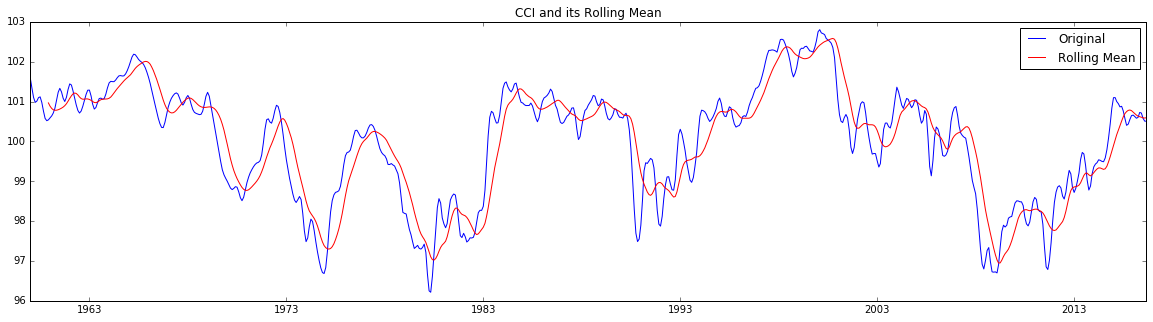


Results of Dickey-Fuller Test (Reg. nc):
Test Statistic                  -0.125184
p-value                          0.641107
#Lags Used                       4.000000
Number of Observations Used    676.000000
Critical Value (5%)             -1.941405
Critical Value (1%)             -2.569055
Critical Value (10%)            -1.616433
dtype: float64

Results of Dickey-Fuller Test (Reg. c):
Test Statistic                  -3.278088
p-value                          0.015887
#Lags Used                      14.000000
Number of Observations Used    666.000000
Critical Value (5%)             -2.865889
Critical Value (1%)             -3.440207
Critical Value (10%)            -2.569086
dtype: float64

Results of Dickey-Fuller Test (Reg. ct):
Test Statistic                  -3.269212
p-value                          0.071471
#Lags Used                      14.000000
Number of Observations Used    666.000000
Critical Value (5%)             -3.417103
Critical Value (1%)             -3.972428
Criti

In [7]:
print 'Tests of stationarity on CCI'
test_stationarity(df)

The Dickey-Fuller Test, under different specifications, suggest that we cannot reject its null hypothesis that the CCI follows a random walk. For this reason, we now test the stationarity of the CCI in differences of one month.

### Test stationarity of CCI in differences

Tests of stationarity on CCI (in differences)


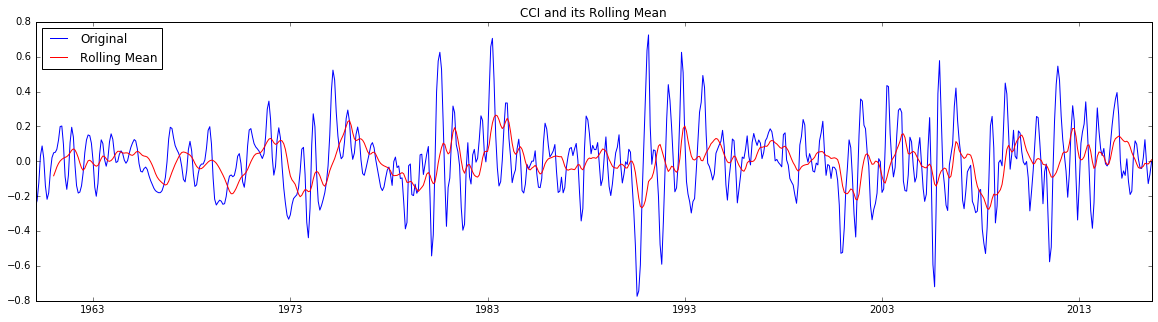


Results of Dickey-Fuller Test (Reg. nc):
Test Statistic                -1.176429e+01
p-value                        2.049708e-21
#Lags Used                     3.000000e+00
Number of Observations Used    6.760000e+02
Critical Value (5%)           -1.941405e+00
Critical Value (1%)           -2.569055e+00
Critical Value (10%)          -1.616433e+00
dtype: float64

Results of Dickey-Fuller Test (Reg. c):
Test Statistic                -1.175590e+01
p-value                        1.178898e-21
#Lags Used                     3.000000e+00
Number of Observations Used    6.760000e+02
Critical Value (5%)           -2.865825e+00
Critical Value (1%)           -3.440061e+00
Critical Value (10%)          -2.569052e+00
dtype: float64

Results of Dickey-Fuller Test (Reg. ct):
Test Statistic                -1.175528e+01
p-value                        9.753881e-19
#Lags Used                     3.000000e+00
Number of Observations Used    6.760000e+02
Critical Value (5%)           -3.417005e+00
Critical 

In [8]:
diff = df.diff()
diff.dropna(inplace=True)
print 'Tests of stationarity on CCI (in differences)'
test_stationarity(diff)

The Dickey-Fuller Test, under different specifications, suggest that we can confidently reject its null hypothesis that the CCI (in differences) follows a random walk. For this reason, we proceed to predict the CCI in differences as a function of its autoregressive and moving-average lags.

### Estimating Parameters for the ARIMA model

In [9]:
from statsmodels.tsa.stattools import acf, pacf
diff_acf = acf(diff, nlags = 20)
diff_pacf = pacf(diff, nlags = 20, method = 'ols')

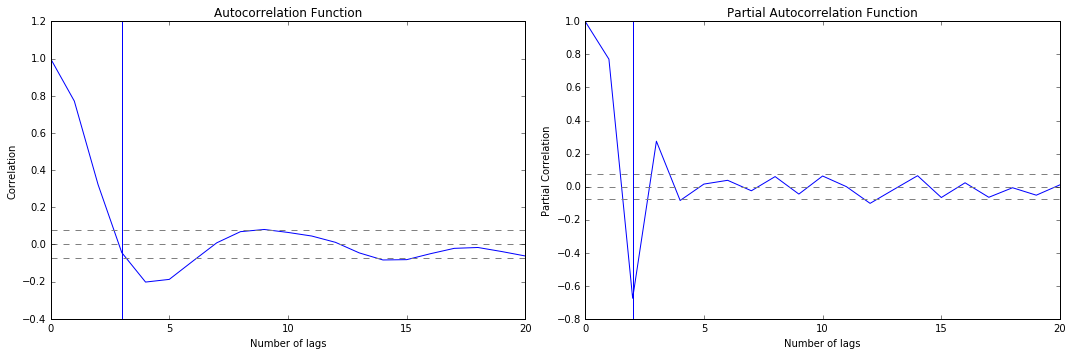

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(diff_acf)
plt.xlabel('Number of lags')
plt.ylabel('Correlation')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.axvline(3)

plt.subplot(122)
plt.plot(diff_pacf)
plt.xlabel('Number of lags')
plt.ylabel('Partial Correlation')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.axvline(2)

plt.tight_layout()
plt.show()

According to the PACF-ACF Heuristic:
- We should pick as p (number of AR lags) the lag for which the upper boundary is first cut in the PACF.
- We should pick as q (number of MA lags) the lag for which the upper boundary is first cut in the ACF.
- For this ARIMA model, p = 2 and q = 3.

Taking this into consideration, we proceed to estimate different ARIMA models with increasing AR terms, and compare them according to three information criteria:

- Akaike Information Criteria (AIC)
- Bayesian Information Criteria (BIC)
- Hannan-Quinn Information Criteria (HQIC)

Given that in our later work we cannot control for moving-average terms, here we'll simply hold constant a MA(3) component for all the ARIMA models, which is the apparent optimal MA term in the ACF. Finally, we consider AR lags up to order 12 so that we consider a model that controls for potential 12-month seasonal dynamics in the CCI differences - which are not apparent in the ACF-PACF charts. 

In [12]:
AICs = []
BICs = []
MLs = []
Ss = []
HQICs = []
Ns = []
for i in range(12):
    model = tsa.ARIMA(df, order=(i+1, 1, 3))
    results = model.fit(disp=-1)
    AICs.append(results.aic)
    BICs.append(results.bic)
    MLs.append(results.llf)
    HQICs.append(results.hqic)
    Ss.append(sum((results.fittedvalues-diff)**2))
    Ns.append(i+1)

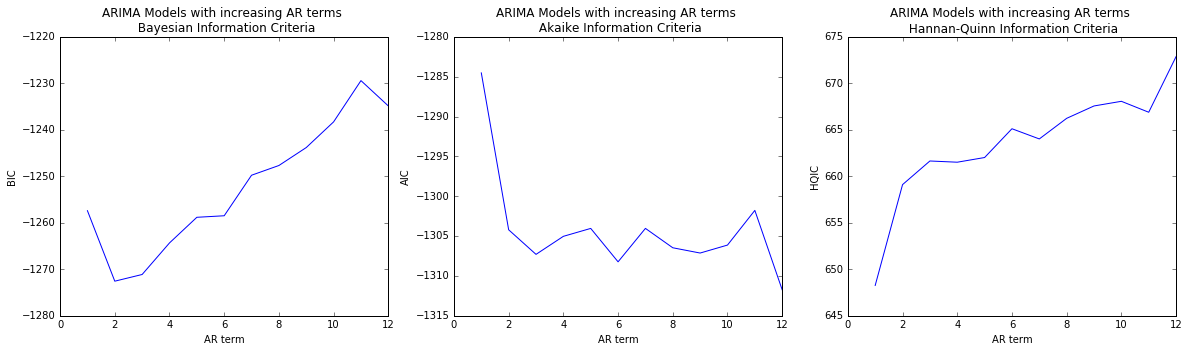

In [15]:
fig = plt.figure(figsize = (20, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax1 = plt.plot(Ns, BICs)
ax1 = plt.title('ARIMA Models with increasing AR terms \n Bayesian Information Criteria')
ax1 = plt.ylabel('BIC')
ax1 = plt.xlabel('AR term')

ax2 = fig.add_subplot(1, 3, 2)
ax2 = plt.plot(Ns, AICs)
ax2 = plt.title('ARIMA Models with increasing AR terms \n Akaike Information Criteria')
ax2 = plt.ylabel('AIC')
ax2 = plt.xlabel('AR term')

ax3 = fig.add_subplot(1, 3, 3)
ax3 = plt.plot(Ns, MLs)
ax3 = plt.title('ARIMA Models with increasing AR terms \n Hannan-Quinn Information Criteria')
ax3 = plt.ylabel('HQIC')
ax3 = plt.xlabel('AR term')

plt.show()

Considering these information criteria, we observe that:

- According to the BIC, the AR(2) model minimizes information loss.
- According to the AIC, the AR(12) model minimizes information loss.
- According to the HQIC, the AR(1) minimizes information loss.

Given all information available, we opt for working with an ARIMA model with AR(2) term and a MA(3) term. 

### Given the optimal p and q, study the AR specification (q = 0), the MA specification (p = 0) and the ARIMA specification.

In order to study whether the joint inclussion of AR and MA terms improves in-sample prediction, below we show the predictions of three different models:
- The AR model, in which the number of MA lags is set to 0 and the AR lags are set to their optimal level.
- The MA model, in which the number of AR lags is set to 0 and the MA lags are set to their optimal level.
- the ARIMA model, in which both the AR and MA lags are set to their optimal level.

Predictions of the AR model - AR(2) MA(0):


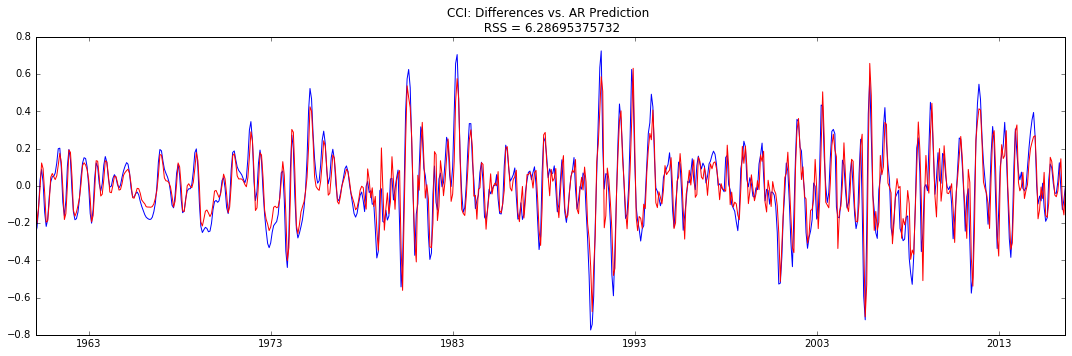

In [18]:
# AR Model
print 'Predictions of the AR model - AR(2) MA(0):'
model_AR = tsa.ARIMA(df, order=(2, 1, 0))
results_AR = model_AR.fit(disp=-1)
plt.figure(figsize = (15,5))
plt.plot(diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('CCI: Differences vs. AR Prediction \n RSS = {}'.format(sum((results_AR.fittedvalues-diff)**2)))
plt.tight_layout()
plt.show()

Predictions of the MA model - AR(0) MA(3):


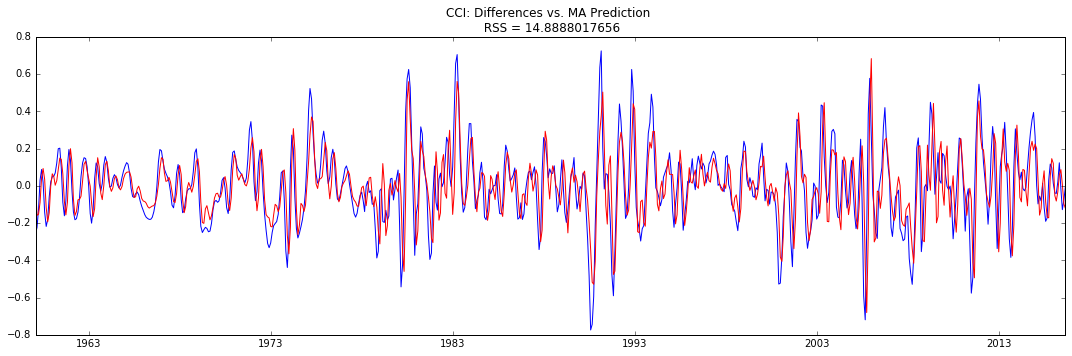

In [19]:
# MA Model - 3 MA lags
print 'Predictions of the MA model - AR(0) MA(3):'
model_MA = tsa.ARIMA(df, order=(0, 1, 3))
results_MA = model_MA.fit(disp=-1, start_params=np.array([.2,.2]))
plt.figure(figsize = (15,5))
plt.plot(diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('CCI: Differences vs. MA Prediction \n RSS = {}'.format(sum((results_MA.fittedvalues-diff)**2)))
plt.tight_layout()
plt.show()

Predictions of the ARIMA model - AR(2) MA(3):


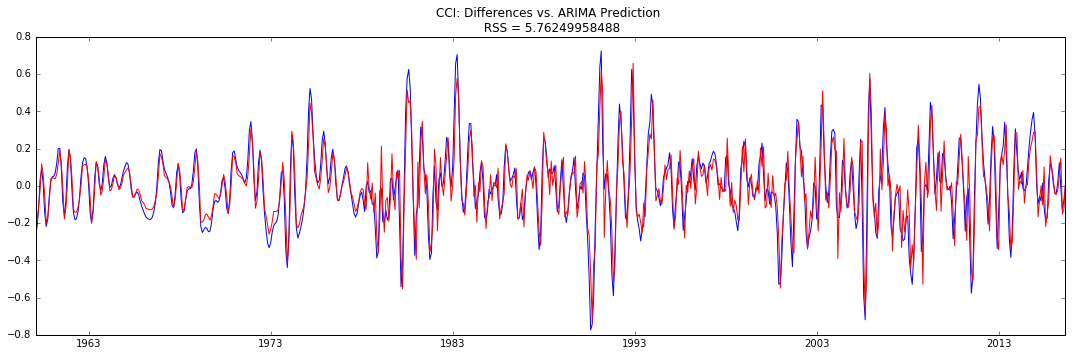

In [20]:
# ARIMA Model
print 'Predictions of the ARIMA model - AR(2) MA(3):'
model_ARIMA = tsa.ARIMA(df, order=(2, 1, 3))
results_ARIMA = model_ARIMA.fit(disp=-1)
plt.figure(figsize = (15,5))
plt.plot(diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('CCI: Differences vs. ARIMA Prediction \n RSS = {}'.format(sum((results_ARIMA.fittedvalues-diff)**2)))
plt.tight_layout()
plt.show()

Of these three specifications, the ARIMA model which incorporates both autoregressive (p=2) and moving average (q=3) regressors yields the lowest RSS scores. Hence, we continue to work with this specification. 

In [21]:
print 'Results summary table for the ARIMA model:'
results_ARIMA.summary2()

Results summary table for the ARIMA model:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 -1272.5557
Dependent Variable: D.Value          Log-Likelihood:      659.11    
Date:               2016-12-13 10:16 Scale:               1.0000    
No. Observations:   680              Method:              css-mle   
Df Model:           6                Sample:              02-01-1960
Df Residuals:       674                                   09-01-2016
Converged:          1.0000           S.D. of innovations: 0.092     
AIC:                -1304.2104       HQIC:                -1291.958 
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const            -0.0017    0.0117  -0.1464  0.8837  -0.0246   0.0212
ar.L1.D.Value     1.0785    0.1041  10.3579  0.0000   0.8744   1.2826
ar.L2.D.Value    -0.4832    0.0563  -8.5907  0.0000  -0.5935  -0.3730
ma.L1.D.Value     0.4300    0.1086   3.9593  0.0001   0.2171   0.6429
ma.L2.D.Value    -0.0031    0.1251  -0.0246  0.9804  -0.2483   0.2422
ma.L3.D.Value    -0.0812    0.0760  -1.0691  0.2854  -0.2301   0.0677
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.1159            -0.9078           1.4385            -0.1087
AR.2            1.1159             0.9078           1.4385             0.1087
MA.1           -1.5381            -1.2986           2.0130            -0.3884
MA.2           -1.5381             1.2986           2.0130             0.3884
MA.3            3.0383            -0.0000           3.0383            -0.0000
====================================================================

"""

### Convert back to the original levels scale and get model score

We reconvert predictions in differences into the original scale and capture the ARIMA model's predictive scores:

In [22]:
raw_preds = pd.Series(results_ARIMA.fittedvalues, copy= True)
sum_preds = raw_preds.cumsum()
pred = pd.Series(df.ix[0], index=df.index)
pred = pred.add(sum_preds, fill_value=0)

In [23]:
from sklearn.linear_model import LinearRegression as LR
x = np.asarray(pred).reshape(len(df), 1)
y = np.asarray(df).reshape(len(df), 1)
lr = LR().fit(x, y)
a = lr.score(x, y)

ARIMA predictions:


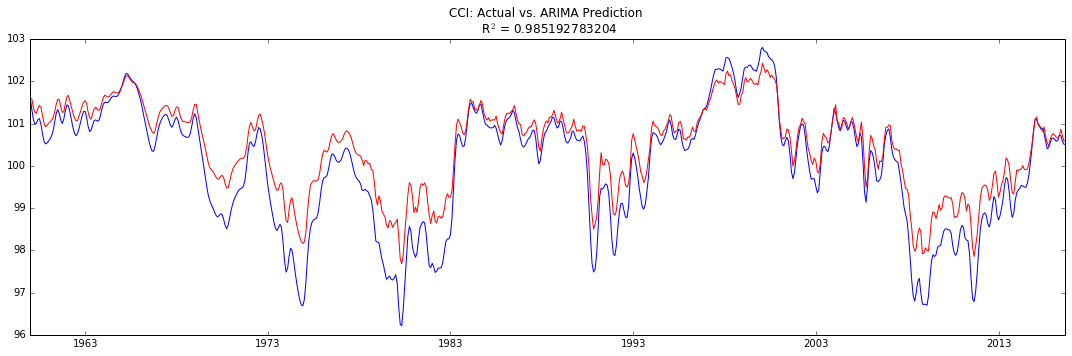

In [24]:
print 'ARIMA predictions:'
plt.figure(figsize = (15,5))
plt.plot(df)
plt.plot(pred, color = 'r')
plt.title('CCI: Actual vs. ARIMA Prediction \n R$^2$ = {}'.format(a))
plt.tight_layout()
plt.show()

These scores suggest that the in-sample benchmark for models including sentiment and topic data is high.

### Testing on future data
Even though the final ARIMA model predicts based only on lagged data, it uses the entire time series to fit the coeffients. Therefore, we will get a more accurate $R^2$ value by fitting on all but the last year and then scoring the last year. The most realistic way to make predictions is by using all data available to fit the ARIMA model and then forecasting one month ahead. As with all ARIMA models, forecasting too far ahead leads to the predicted values converging to the expected value of the stationary series. Therefore, we now iteratively fit the data on a roll-forward format, predicting CCI and then use the resulting model to forecast one month ahead until we have 'out-of-sample' forecasts for the last 12 months.

In [29]:
futureRange = 12
model_ARIMA = tsa.ARIMA(df.iloc[:-futureRange], order=(2, 1, 3))
results_ARIMA = model_ARIMA.fit(disp=-1)

In [30]:
raw_preds = pd.Series(results_ARIMA.fittedvalues, copy= True)
sum_preds = raw_preds.cumsum()
pred = sum_preds + df.ix[0]

In [31]:
allFuture = np.zeros(futureRange)
for i in range(futureRange):
    model_ARIMA = tsa.ARIMA(df.iloc[:-futureRange+i], order=(2, 1, 3))
    results_ARIMA = model_ARIMA.fit(disp=-1, maxiter=100)
    allFuture[i] = results_ARIMA.forecast(steps=1)[0]

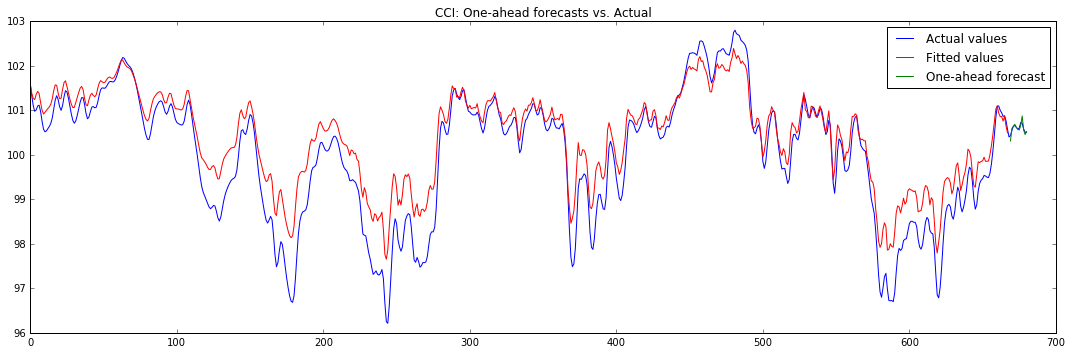

In [32]:
# ARIMA Model - Roll forward forecasting for the last 12 months.

plt.figure(figsize = (15,5))
plt.plot(df.values, label='Actual values')
plt.plot(pred.values, color='red', label='Fitted values')
plt.plot(np.concatenate((np.full(len(df)-futureRange,np.nan),allFuture)), color='green', label='One-ahead forecast')
plt.title('CCI: One-ahead forecasts vs. Actual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [34]:
'R2 score for Roll-Forward predictions for the last 12 months: {:.3f}'.format(r2_score(df.iloc[-futureRange:].values, allFuture))

'R2 score for Roll-Forward predictions for the last 12 months: 0.356'

As we can see, fitting an ARIMA model with just the previous CCI time series is quite successful at making forecasts one month ahead out of sample. This score is hence our roll-forward benchmark for any model including sentiment and topic data from the New York Times news.